In [49]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/jacksondivakarr/laptop-price-prediction-dataset")

Skipping, found downloaded files in ".\laptop-price-prediction-dataset" (use force=True to force download)


In [80]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer

In [51]:
df = pd.read_csv("laptop-price-prediction-dataset/data.csv")

In [52]:
df.head()

,Unnamed: 0.1,Unnamed: 0,brand,name,price,spec_rating,processor,CPU,Ram,Ram_type,ROM,ROM_type,GPU,display_size,resolution_width,resolution_height,OS,warranty
0,0,0,HP,Victus 15-fb0157AX Gaming Laptop,49900,73.000000,5th Gen AMD Ryzen 5 5600H,"Hexa Core, 12 Threads",8GB,DDR4,512GB,SSD,4GB AMD Radeon RX 6500M,15.6,1920.0,1080.0,Windows 11 OS,1
1,1,1,HP,15s-fq5007TU Laptop,39900,60.000000,12th Gen Intel Core i3 1215U,"Hexa Core (2P + 4E), 8 Threads",8GB,DDR4,512GB,SSD,Intel UHD Graphics,15.6,1920.0,1080.0,Windows 11 OS,1
2,2,2,Acer,One 14 Z8-415 Laptop,26990,69.323529,11th Gen Intel Core i3 1115G4,"Dual Core, 4 Threads",8GB,DDR4,512GB,SSD,Intel Iris Xe Graphics,14.0,1920.0,1080.0,Windows 11 OS,1
3,3,3,Lenovo,Yoga Slim 6 14IAP8 82WU0095IN Laptop,59729,66.000000,12th Gen Intel Core i5 1240P,"12 Cores (4P + 8E), 16 Threads",16GB,LPDDR5,512GB,SSD,Intel Integrated Iris Xe,14.0,2240.0,1400.0,Windows 11 OS,1
4,4,4,Apple,MacBook Air 2020 MGND3HN Laptop,69990,69.323529,Apple M1,Octa Core (4P + 4E),8GB,DDR4,256GB,SSD,Apple M1 Integrated Graphics,13.3,2560.0,1600.0,Mac OS,1


In [53]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 893 entries, 0 to 892
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0.1       893 non-null    int64  
 1   Unnamed: 0         893 non-null    int64  
 2   brand              893 non-null    str    
 3   name               893 non-null    str    
 4   price              893 non-null    int64  
 5   spec_rating        893 non-null    float64
 6   processor          893 non-null    str    
 7   CPU                893 non-null    str    
 8   Ram                893 non-null    str    
 9   Ram_type           893 non-null    str    
 10  ROM                893 non-null    str    
 11  ROM_type           893 non-null    str    
 12  GPU                893 non-null    str    
 13  display_size       893 non-null    float64
 14  resolution_width   893 non-null    float64
 15  resolution_height  893 non-null    float64
 16  OS                 893 non-null    st

In [54]:
df.shape

(893, 18)

In [55]:
for col in df.columns:
    print(col,":", df[col].nunique())

Unnamed: 0.1 : 893
Unnamed: 0 : 893
brand : 30
name : 815
price : 464
spec_rating : 30
processor : 184
CPU : 29
Ram : 7
Ram_type : 12
ROM : 7
ROM_type : 2
GPU : 134
display_size : 18
resolution_width : 18
resolution_height : 22
OS : 14
warranty : 4


In [56]:
def sanitization(df):
    
    print("Shape before dropping id column: \n", df.shape)
    print("\n")
    print("The number of missing values in each columns are \n", df.isnull().sum())
    print("\n")
    print("The number of duplicate rows are: ", df.duplicated().sum())
    df = df.drop(["Unnamed: 0.1", "Unnamed: 0"], axis=1, inplace=True)
    
    

sanitization(df)

Shape before dropping id column: 
 (893, 18)


The number of missing values in each columns are 
 Unnamed: 0.1         0
Unnamed: 0           0
brand                0
name                 0
price                0
spec_rating          0
processor            0
CPU                  0
Ram                  0
Ram_type             0
ROM                  0
ROM_type             0
GPU                  0
display_size         0
resolution_width     0
resolution_height    0
OS                   0
warranty             0
dtype: int64


The number of duplicate rows are:  0


In [57]:
df.shape

(893, 16)

In [58]:
num_cols = [
    "price",
    "spec_rating",
    "display_size",
    "resolution_width",
    "resolution_height",
    "warranty"
]


In [59]:
cat_cols = ["brand", "processor", "CPU","Ram_type", "ROM_type","GPU", "OS"]

In [60]:
df["Ram"] = df["Ram"].str.extract(r"(\d+)").astype(int)
df["ROM"] = df["ROM"].str.extract(r"(\d+)").astype(int)
num_cols += ["Ram", "ROM"]

In [61]:
corr = df[num_cols].corr()

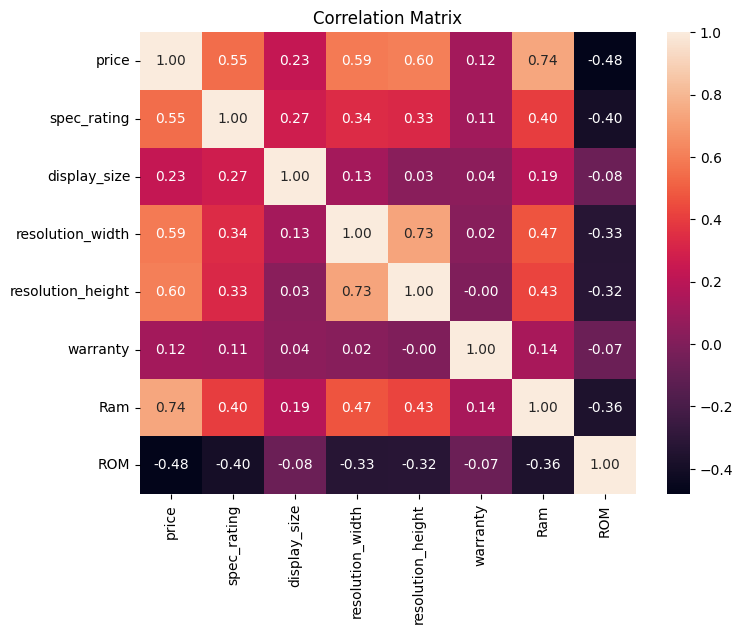

In [62]:
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

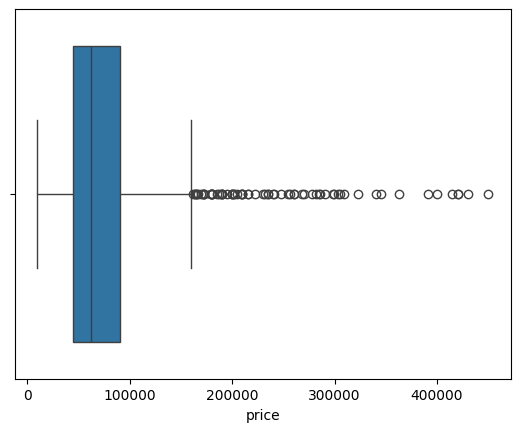

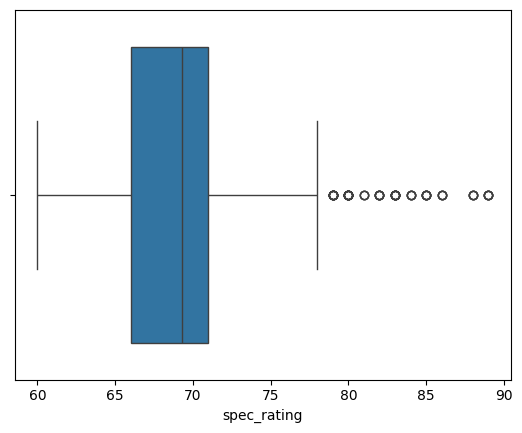

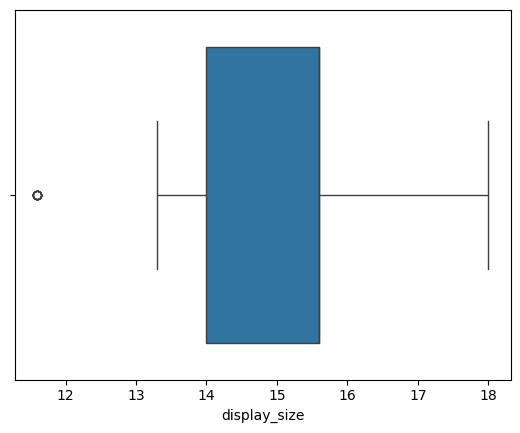

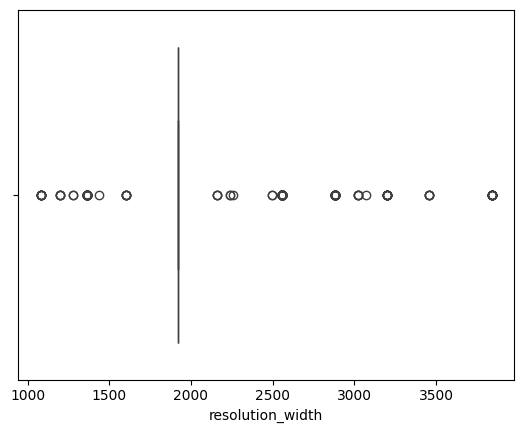

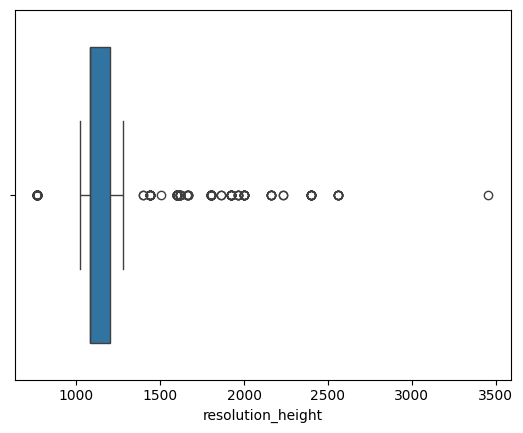

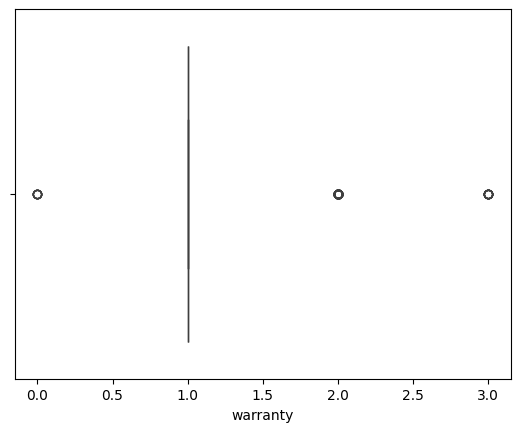

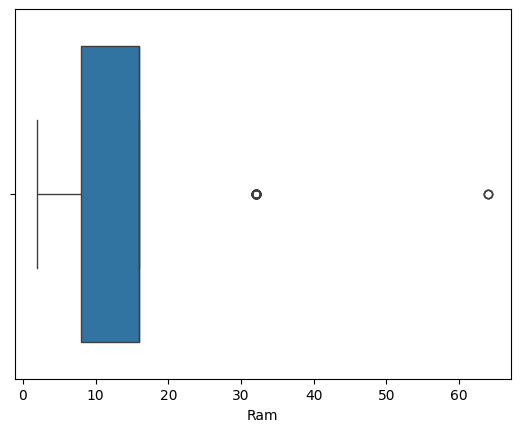

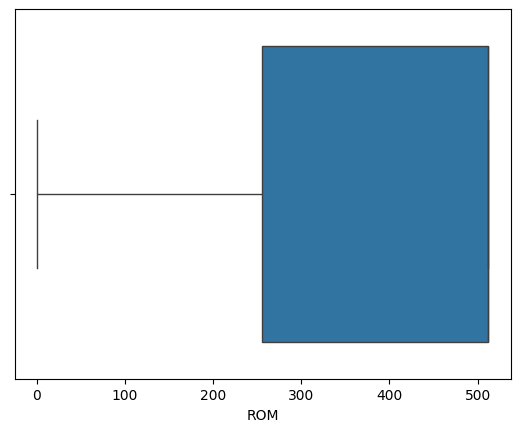

In [63]:
for col in num_cols:
    sns.boxplot(x=df[col])
    plt.show()

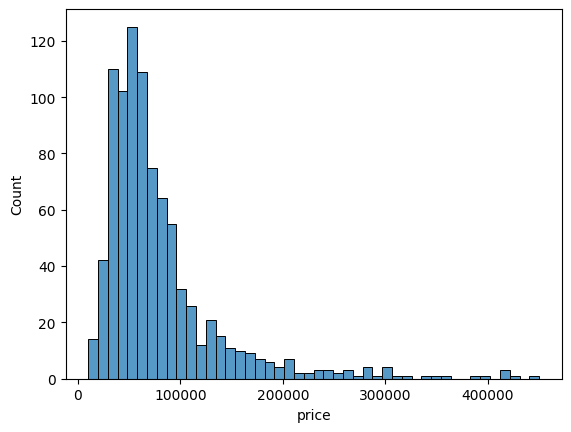

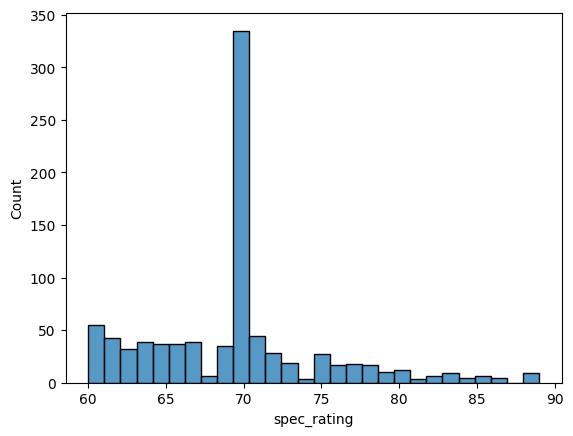

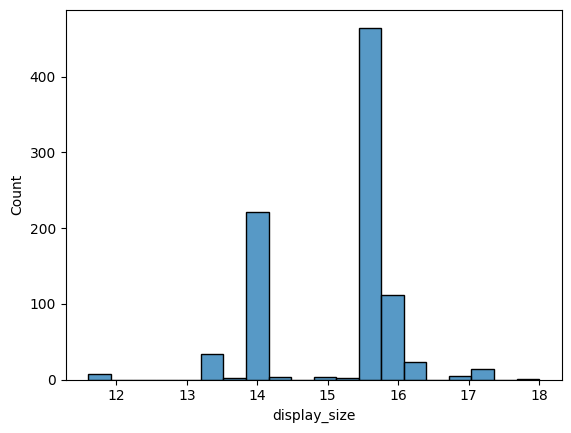

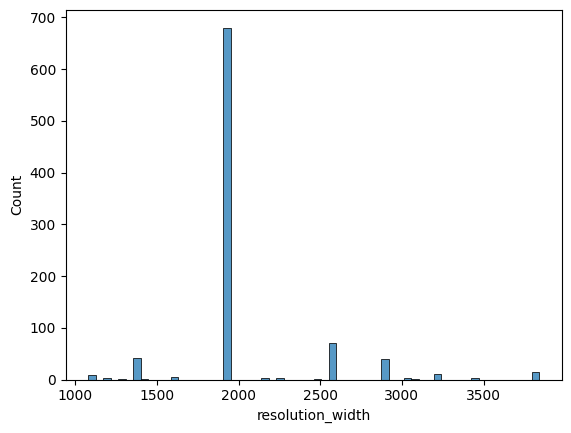

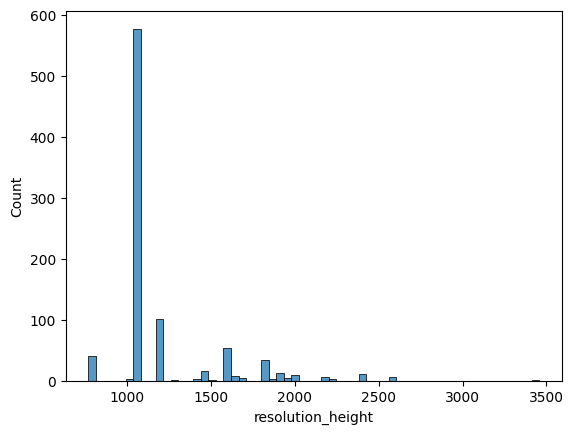

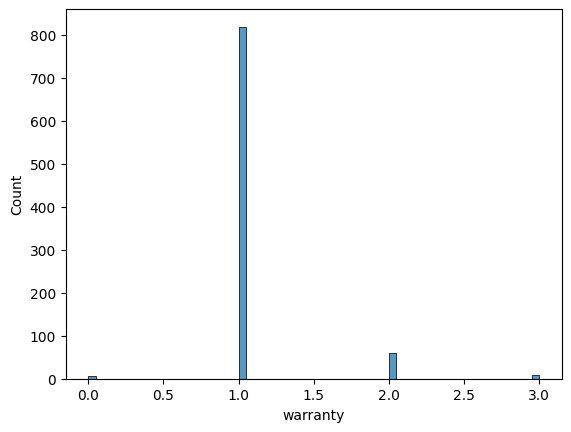

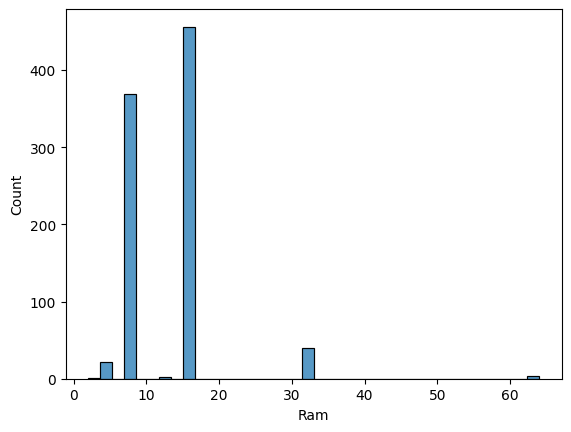

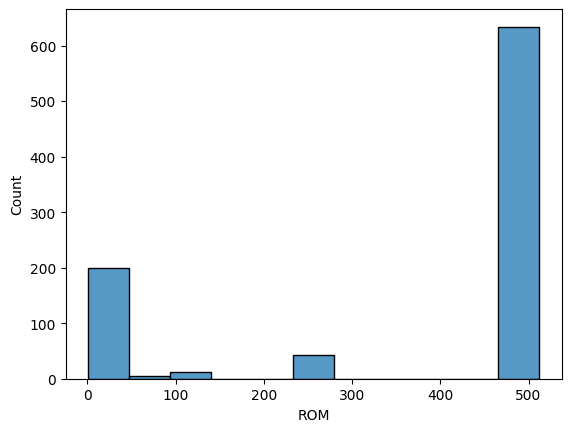

In [64]:
for col in num_cols:
    sns.histplot(x=df[col])
    plt.show()

In [65]:

Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1
mask = ~((df[num_cols] < (Q1 - 1.5 * IQR)) | (df[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)
df = df[mask]
print(df.shape)

(605, 16)


In [66]:
y = df["price"]
X = df.drop(columns=["price"])

In [67]:
X.shape, y.shape

((605, 15), (605,))

In [68]:
X_train, X_test, y_train, y_test = train_test_split( X,y,test_size=0.2,random_state=42)

In [75]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), [col for col in num_cols if col != "price"]),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

In [76]:
pipe = Pipeline([
    ("prep", preprocessor),
    ("knn", KNeighborsRegressor())
])

In [77]:
pipe.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('knn', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains spa

In [78]:

y_pred = pipe.predict(X_test)

In [79]:
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

MAE: 8821.862809917357
RMSE: 162621327.51041323
R2: 0.7458842524283298


In [81]:
param_grid = {
    "knn__n_neighbors": range(3, 31),
    "knn__weights": ["uniform", "distance"]
}

gs = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

gs.fit(X_train, y_train)

print("Best params:", gs.best_params_)
print("Best MAE:", -gs.best_score_)

Best params: {'knn__n_neighbors': 4, 'knn__weights': 'distance'}
Best MAE: 9018.849315330133
